In [1]:
import os

if not os.path.exists('/content/police-records-project'):
    !git clone https://github.com/c-goenka/police-records-project.git
    %cd /content/police-records-project
    !pip install -r requirements.txt
else:
    %cd /content/police-records-project

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'police-records-project'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 120 (delta 61), reused 99 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 105.71 KiB | 15.10 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/police-records-project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
data_dir = "/content/drive/MyDrive/police-records-project-data/processed"

train_df = pd.read_csv(f"{data_dir}/train.csv")
test_df = pd.read_csv(f"{data_dir}/test.csv")

print(f"Train: {len(train_df)} documents")
print(f"Test: {len(test_df)} documents\n")
print(f"Classes: {train_df['label'].nunique()}")
print(f"Labels: {sorted(train_df['label'].unique())}")

Train: 75 documents
Test: 23 documents

Classes: 11
Labels: ['discovery-package', 'emails-memorandum-correspondence', 'police-commision-agenda', 'press-release', 'reports-coroners', 'reports-criminal', 'reports-death-in-custody', 'reports-incident', 'reports-investigation', 'reports-supplemental', 'reports-use-of-force']


In [4]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(model_name)

print(f"Model loaded: {model_name}")
print(f"Model dimensions: {model.get_sentence_embedding_dimension()}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded: sentence-transformers/all-mpnet-base-v2
Model dimensions: 768


In [5]:
X_train = model.encode(
    train_df['text_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

X_test = model.encode(
    test_df['text_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"Train embeddings shape: {X_train.shape}")
print(f"Test embeddings shape: {X_test.shape}")

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train embeddings shape: (75, 768)
Test embeddings shape: (23, 768)


In [6]:
classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_SEED
    ),
    'SVM': SVC(
        kernel='rbf',
        class_weight='balanced',
        random_state=RANDOM_SEED
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=RANDOM_SEED
    )
}

In [7]:
results = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = (y_test == y_pred).mean()

    results[name] = {
        'model': clf,
        'predictions': y_pred,
        'macro_f1': macro_f1,
        'accuracy': accuracy
    }

    print(f"  Macro F1: {macro_f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f} ({(y_test == y_pred).sum()}/{len(y_test)})")
    print(f"  Correct predictions: {(y_test == y_pred).sum()}/{len(y_test)}\n")

Training Logistic Regression...
  Macro F1: 0.5195
  Accuracy: 0.6087 (14/23)
  Correct predictions: 14/23

Training SVM...
  Macro F1: 0.5864
  Accuracy: 0.6522 (15/23)
  Correct predictions: 15/23

Training Random Forest...
  Macro F1: 0.6000
  Accuracy: 0.6957 (16/23)
  Correct predictions: 16/23



In [8]:
results_df = pd.DataFrame({
  'text': test_df['text_clean'],
  'true_label': y_test,
  'pred_label': y_pred,
  'correct': y_test == y_pred
})

output_path = f"{data_dir}/embeddings_classifier_results.csv"
results_df.to_csv(output_path, index=False)

print(f"Saved results to: {output_path}")

Saved results to: /content/drive/MyDrive/police-records-project-data/processed/embeddings_classifier_results.csv


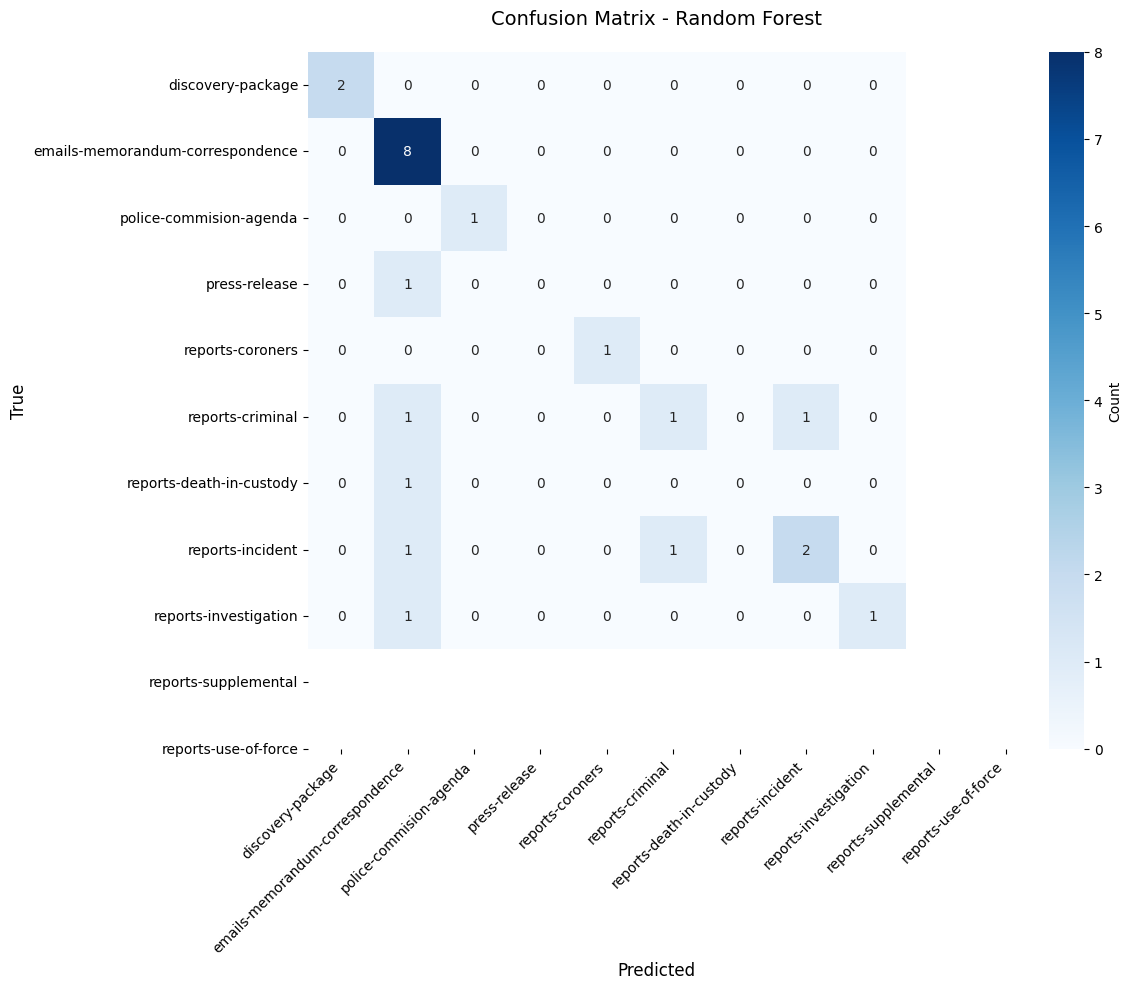

In [9]:
cm = confusion_matrix(y_test, results['Random Forest']['predictions'])
labels = sorted(train_df['label'].unique())

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Count'}
)

plt.title(f'Confusion Matrix - Random Forest', fontsize=14, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()
plt.show()